In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

torch.cuda.is_available()

True

In [ ]:
with open('pg100.txt', 'r') as f:
    data1 = f.read()
with open('pg2600.txt', 'r') as f:
    data2 = f.read()
with open('pg71990.txt', 'r') as f:
    data3 = f.read()

def data_split(data):
  train_test_len = round(len(data)*0.8)
  train, test_data = data[:train_test_len], data[train_test_len:]
  train_val_len = round(train.size*0.8)
  train_data,val_data = train[:train_val_len], train[train_val_len:]
  return train_data, val_data, test_data

data = data1 + data2 + data3
chars = tuple(set(data))
int2char = dict(enumerate(chars))
char2int = {v: k for k, v in int2char.items()}
data1=list(data1)
data2=list(data2)
data3=list(data3)
data1 = np.array([char2int[k] for k in data1])
data2 = np.array([char2int[k] for k in data2])
data3 = np.array([char2int[k] for k in data3])

train1, val1, test1 = data_split(data1)
train2, val2, test2 = data_split(data2)
train3, val3, test3 = data_split(data3)
train_data = np.concatenate((train1,train2,train3))
val_data = np.concatenate((val1, val2, val3))
test_data = np.concatenate((test1, test2, test3))

In [ ]:
def loader(data, num__of_seq, seq_length):
    data = np.array(list(data))
    batch_size = num__of_seq * seq_length
    batchnum = len(data) // batch_size
    data = data[:batchnum * batch_size]
    data = data.reshape((num__of_seq, -1))

    for i in range(0, data.shape[1] - seq_length, seq_length):
        input = data[:, i : i + seq_length]
        label = np.zeros_like(input)
        label[:, :-1], label[:, -1] = input[:, 1:], data[:, i + seq_length]
        yield input, label

def one_hot_encoding(input, num_chars):
    one_hot = np.zeros((input.shape[0] * input.shape[1], num_chars), dtype=np.float32)
    one_hot=np.eye(num_chars,dtype=np.float32)[input.reshape(-1)]
    one_hot = one_hot.reshape((input.shape[0], input.shape[1], num_chars))

    return one_hot

In [ ]:
epochs=50
num__of_seq=64
seq_length=32
num_chars = len(chars)
lr=0.001
device = torch.device("cuda:0")

In [ ]:
class LSTM(nn.Module):
    def __init__(self, chars, n_hidden=256, n_layers=3, drop_prob=0.5):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.chars = chars
        self.lstm = nn.LSTM(num_chars, n_hidden, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden,num_chars)

    def forward(self, input, hidden):
        outputs, hidden = self.lstm(input, hidden)
        outputs = self.dropout(outputs)
        outputs = self.fc(outputs)

        return outputs, hidden

In [ ]:
net = LSTM(chars, n_hidden=256, n_layers=3)
net.train()
net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_function = torch.nn.CrossEntropyLoss()


summary = {'loss': [], 'val_loss': []}
for epoch in range(epochs):
  hidden = None
  i = 0
  for input, label in loader(train_data, num__of_seq, seq_length):
    input = one_hot_encoding(input,num_chars)
    input = torch.from_numpy(input).to(device)
    label = torch.tensor(label, dtype=torch.long).to(device)
    outputs, hidden = net.forward(input, hidden)
    loss = loss_function(outputs.view(num__of_seq * seq_length, num_chars), label.view(num__of_seq * seq_length))
    loss.backward()
    nn.utils.clip_grad_norm_(net.parameters(), 5)
    optimizer.step()
    optimizer.zero_grad()
    hidden = (hidden[0].detach(), hidden[1].detach())
    summary['loss'].append(loss.item())

    if i!=0 and i%1000 == 0:
      with torch.no_grad():
        val_hidden = None
        val_loss_all = []
        for input, label in loader(val_data, num__of_seq, seq_length):
          input = one_hot_encoding(input,num_chars)
          input = torch.from_numpy(input).to(device)
          label = torch.tensor(label, dtype=torch.long).to(device)
          outputs, val_hidden = net.forward(input, val_hidden)
          val_loss = loss_function(outputs.view(num__of_seq * seq_length, num_chars), label.view(num__of_seq * seq_length))
          val_loss_all.append(val_loss.item())
          avg_val_loss = np.mean(val_loss_all)
      summary['val_loss'].append(avg_val_loss)
      print('Epoch: ', epoch+1, ' update: ',i,' validation loss: ', avg_val_loss)

    i += 1

Epoch:  1  update:  1000  validation loss:  2.427649110682828
Epoch:  1  update:  2000  validation loss:  2.1890885863839986
Epoch:  2  update:  1000  validation loss:  2.0005354586230912
Epoch:  2  update:  2000  validation loss:  1.930718552337093
Epoch:  3  update:  1000  validation loss:  1.8526414086774605
Epoch:  3  update:  2000  validation loss:  1.8162838262989376
Epoch:  4  update:  1000  validation loss:  1.77838240951766
Epoch:  4  update:  2000  validation loss:  1.7563578449984534
Epoch:  5  update:  1000  validation loss:  1.7326546408882522
Epoch:  5  update:  2000  validation loss:  1.7174960992075132
Epoch:  6  update:  1000  validation loss:  1.7012509633263686
Epoch:  6  update:  2000  validation loss:  1.6886689240698456
Epoch:  7  update:  1000  validation loss:  1.6808036921882359
Epoch:  7  update:  2000  validation loss:  1.6689890757054726
Epoch:  8  update:  1000  validation loss:  1.6576791559140678
Epoch:  8  update:  2000  validation loss:  1.6515333521925

Text(0.5, 1.0, 'Train loss (per 500 updates)')

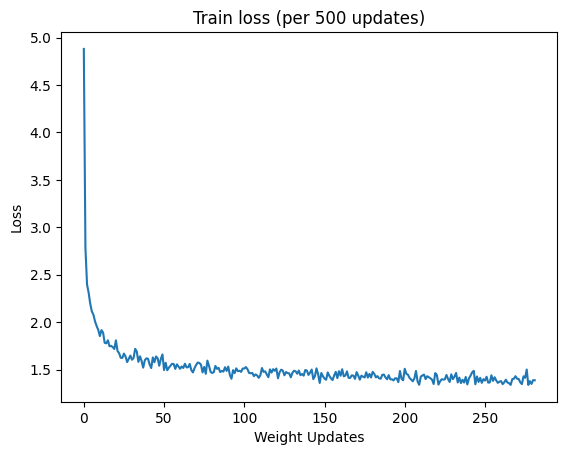

In [ ]:
plt.plot(summary['loss'][::500])
plt.xlabel('Weight Updates')
plt.ylabel('Loss')
plt.title("Train loss (per 500 updates)")

Text(0.5, 1.0, 'Validation loss (per 1k updates)')

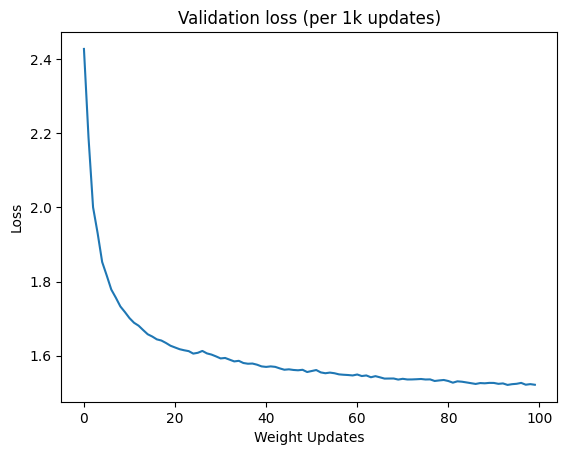

In [ ]:
plt.plot(summary['val_loss'])
plt.xlabel('Weight Updates')
plt.ylabel('Loss')
plt.title("Validation loss (per 1k updates)")

In [ ]:
def predict(net, input):
    net.to(device)
    net.eval()

    chars = []
    hidden = None
    for ip in input:
        with torch.no_grad():
            ip = np.array([[char2int[ip]]])
            ip = one_hot_encoding(ip, len(net.chars))
            ip = torch.from_numpy(ip).to(device)
            out, hidden = net.forward(ip, hidden)

            logit = torch.nn.functional.softmax(out, dim=2).data.to('cpu')
            char = int2char[int(torch.argmax(logit))]
    chars.append(char)

    for index in range(32):
        input = np.array([[char2int[chars[-1]]]])
        input = one_hot_encoding(input, len(net.chars))
        input = torch.from_numpy(input).to(device)
        out, hidden = net.forward(input, hidden)

        logit = torch.nn.functional.softmax(out, dim=2).data.to('cpu')
        char = int2char[int(torch.argmax(logit))]
        chars.append(char)

    return ''.join(chars)

In [ ]:
input = train_data[1200:1250]
input = [int2char[i] for i in list(input)]
input = "".join(input)
print("input: ",input,"\n")
print("prediction: ",input + predict(net, input=input))

input:  KING HENRY THE FOURTH
    THE LIFE OF KING HENRY T 

prediction:  KING HENRY THE FOURTH
    THE LIFE OF KING HENRY THE ENOBARATO, a thing of the Coun


In [ ]:
input = val_data[1200:1250]
input = [int2char[i] for i in list(input)]
input = "".join(input)
print("input: ",input,"\n")
print("prediction: ",input + predict(net, input=input))

input:  rank one.

DESDEMONA.
You may indeed say so,
For ’ 

prediction:  rank one.

DESDEMONA.
You may indeed say so,
For ’tis the state of the state of the


In [ ]:
input = test_data[1200:1250]
input = [int2char[i] for i in list(input)]
input = "".join(input)
print("input: ",input,"\n")
print("prediction: ",input + predict(net, input=input))

input:  r there
Does not become a man; ’tis much to blame. 

prediction:  r there
Does not become a man; ’tis much to blame.

 [_Exeunt an Antony and Soldier
